# RÉSEAU AÉRIEN EUROPÉEN

## INTRODUCTION

La plate-forme de correspondance aéroportuaire ou hub est l'aéroport choisi par une compagnie aérienne pour y faire transiter une partie notable de ses vols et y assurer des correspondances rapides et garanties.

Le concept vient des États-Unis, plus précisément de Dallas Fort Worth, où la compagnie American Airlines l’a lancé au début des années 1980. Elle disposait pour cela d’un aéroport spécialement conçu pour les correspondances. L'Europe a adopté ce dispositif au début des années 1980.

Le trafic aérien intra européen ne cesse de croître, il est passé de 115 millions de passagers en 1980 à 491 188 millions en 2017. L’Organisation de l’Aviation Civile Internationale (ICAO) estime que le nombre de passagers aériens intra européen pourraient atteindre le milliard d’ici 2030.

Cette augmentation effrénée du trafic remet en cause les modèles logistiques et d’infrastructures actuelles des aéroports. De nombreuses études ont été menées au niveau mondial, mais aucune n'a été réalisée sur le réseau européen.

**Ces éléments amènent à s'interroger sur l'importance des hubs dans le réseau de transport aérien européen ?**


## PRÉREQUIS

#### OUTILS

Pour pouvoir apporter plus d'informations sur cette problématique, il faut installer les outils suivants :

* Python : 2.7
* Jupyter : 5.7.8
* Geos : 3.8.0


#### IMPORT DES LIBRAIRIES

Librairies :

* Math fournies des fonctions mathématiques
* Networkx : étudie des graphes et des réseaux.
* Pandas : aide à manipuler et analyser des données
* Matplotlib : permets de tracer et visualiser des données sous forme de graphiques 
* Basemap : permets de tracer des données 2D sur des cartes


In [1]:
import math as m
from math import sin, cos, sqrt, atan2, radians, asin
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.lines as mlines
import geopy as geo

## MISE EN PLACE

### RÉCUPÉRATION DES DONNÉES

2 fichiers ont été récupéré sur le site [Openflights](https://openflights.org/data.html), les données datent de 2017. Les données récemment mises à jour étaient uniquement disponibles sur des plateformes payantes.

* airports.dat : fournit la liste de tous les aéroports présents dans le monde en 2017.
* routes.dat : fournit la liste de toutes les routes aériennes entre chaque aéroport en 2017.


#### Aéroports

Dans un premier temps on exporte l'ensemble des aéroports du fichier dans un dataframe.

On filtre la dataframe sur la colonne du **fuseau horaire des aéroports** pour ne récupérer que ceux faisant partie de l'Europe.

On créer une liste d'identifiants de ces aéroports.

*NB : Le jeu de données récupéré ne contenait pas l'ensemble des codes IATAS , ceux n'ayant pas leur code ont été retirés de l'analyse.*


In [2]:
airports = pd.read_csv("airports.dat", sep=',', names=["id","nom","ville","pays","iata","oaci","latitude","longitude","altitude","fuseau_horaire","continent","fuseau_horaire_bdd","type","source"],index_col = 0)

#On filtre les aeroports pour ne recuperer que les aeroport basés sur le fuseau horaire européen
european_airports = airports[airports.fuseau_horaire_bdd.str.startswith("Europe/")]
european_airports = european_airports[european_airports['iata'] != '\N']

print ("Il y a " + str(len(european_airports)) + " aeroports européens")
european_airports.head()

Il y a 957 aeroports européens


nom              ville     pays iata  \
id                                                                             
299  Antwerp International Airport (Deurne)            Antwerp  Belgium  ANR   
302                        Brussels Airport           Brussels  Belgium  BRU   
304        Brussels South Charleroi Airport          Charleroi  Belgium  CRL   
308                        Wevelgem Airport  Kortrijk-vevelgem  Belgium  KJK   
309                           Liège Airport              Liege  Belgium  LGG   

     oaci   latitude  longitude  altitude fuseau_horaire continent  \
id                                                                   
299  EBAW  51.189400    4.46028        39              1         E   
302  EBBR  50.901402    4.48444       184              1         E   
304  EBCI  50.459202    4.45382       614              1         E   
308  EBKT  50.817200    3.20472        64              1         E   
309  EBLG  50.637402    5.44322       659              1         E   

    fuseau_horaire_bdd     type       source  
id                                            
299    Europe/Brussels  airport  OurAirports  
302    Europe/Brussels  airport  OurAirports  
304    Europe/Brussels  airport  OurAirports  
308    Europe/Brussels  airport  OurAirports  
309    Europe/Brussels  airport  OurAirports

#### Routes aériennes

Dans un second temps on récupère les routes aériennes.

On filtre le dataframe avec la liste des aéroports précédemment créée, on ne garde que les trajets européens, il faut donc que l'aéroport de départ et l'aéroport d'arrivée fassent partie de la liste d'aéroport.

In [3]:
routes = pd.read_csv("routes.dat", sep=',', names=["compagnie_aerienne","id_compagnie_aerienne","aeroport_source","id_aeroport_source","aeroport_destination","id_aeroport_destination","partage_code","arrets","equipement"])
routes['id_aeroport_source'] = pd.to_numeric(routes['id_aeroport_source'].astype(str), 'coerce')
routes['id_aeroport_destination'] = pd.to_numeric(routes['id_aeroport_destination'].astype(str), 'coerce')
routes_european = routes[(routes['id_aeroport_source'].isin(european_airports.index.values)) &  (routes['id_aeroport_destination'].isin(european_airports.index.values))]
print ("Il y a " + str(len(routes_european)) + " trajets européen")
routes_european.head()

Il y a 15909 trajets européen


compagnie_aerienne id_compagnie_aerienne aeroport_source  \
0                 2B                   410             AER   
1                 2B                   410             ASF   
2                 2B                   410             ASF   
5                 2B                   410             DME   
6                 2B                   410             DME   

   id_aeroport_source aeroport_destination  id_aeroport_destination  \
0              2965.0                  KZN                   2990.0   
1              2966.0                  KZN                   2990.0   
2              2966.0                  MRV                   2962.0   
5              4029.0                  KZN                   2990.0   
6              4029.0                  NBC                   6969.0   

  partage_code  arrets equipement  
0          NaN       0        CR2  
1          NaN       0        CR2  
2          NaN       0        CR2  
5          NaN       0        CR2  
6          NaN       0        CR2

### ANALYSE

#### REPRÉSENTATION GÉOGRAPHIQUE DES ROUTES EUROPÉENNES

On créer une fonction où l'on va générer notre graphe en fonction de la liste des aéroports, routes, et du nombre de connexions par aéroport en Europe. Cette fonction pourra être appelée à plusieurs reprises pour tester différents jeux de données.

In [4]:
def generate_geo_graph (european_airports, routes_european,counts,title):
    if (european_airports is None) or (routes_european is None):
        print "Les données ne peuvent pas être lu"
    else:
        pos_data = counts.merge(european_airports, on = 'id')
        graphspat = nx.from_pandas_edgelist(routes_european, 'id_aeroport_source','id_aeroport_destination', edge_attr = 'counts')
        # Set up base map
        plt.figure(figsize=(20,20))
        m = Basemap(projection='merc',llcrnrlon=-30, llcrnrlat=15, urcrnrlon=55, urcrnrlat=80,lat_ts=0,resolution='l',suppress_ticks=True)

        # import long lat as m attribute
        mx, my = m(pos_data['longitude'].values, pos_data['latitude'].values)
        pos = {}
        for count, elem in enumerate (pos_data['id']):
            pos[elem] = (mx[count], my[count])
        large_airports = [x for x in graphspat.nodes() if (counts['total_routes'][x] >= 200)];
        large_size = [counts['total_routes'][x]*4 for x in graphspat.nodes() if counts['total_routes'][x] >= 200]
        large_labels = {x:x for x in graphspat.nodes() if counts['total_routes'][x] >= 200}
        
        small_airports = [x for x in graphspat.nodes() if (counts['total_routes'][x] < 200)];
        small_size = [counts['total_routes'][x]*2 for x in graphspat.nodes() if counts['total_routes'][x] < 200]
        

        nx.draw_networkx_nodes(G = graphspat, pos = pos, nodelist = large_airports,node_color = 'r', alpha = 0.8,node_size = large_size)
        nx.draw_networkx_nodes(G = graphspat, pos = pos, nodelist = small_airports,node_color = 'b', alpha = 0.6,node_size = small_size)
        nx.draw_networkx_labels(G = graphspat, pos = pos, font_size=10,labels = large_labels)
        nx.draw_networkx_edges(G = graphspat, pos = pos, edge_color = 'green', width = routes_european['counts']*1, alpha=0.08, arrows = False)


        m.drawcountries(linewidth = 1)
        m.drawstates(linewidth = 0.2)
        m.drawcoastlines(linewidth=1)
        m.fillcontinents(alpha = 0.3)

        line1 = mlines.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="red")
        line2 = mlines.Line2D(range(1), range(1), color="white", marker='o',markerfacecolor="blue")
        line3 = mlines.Line2D(range(1), range(1), color="green", marker='',markerfacecolor="green")
        plt.legend((line1, line2, line3), ('Gros aeroports', 'Petit aeroports', 'routes'),loc=4, fontsize = 'xx-large')
        plt.title(title, fontsize = 30)
        plt.tight_layout()
        plt.show()
        return nx, graphspat

On initialise une nouvelle colonne dans la liste des aéroports européens, elle contiendra le nombre de connexions total de chaque aéroport.

On regroupe les routes par aéroport de départ et d'arrivée, on récupère le nombre de connexions pour chaque aéroport et on les ajoute dans la colonne précédemment créée.

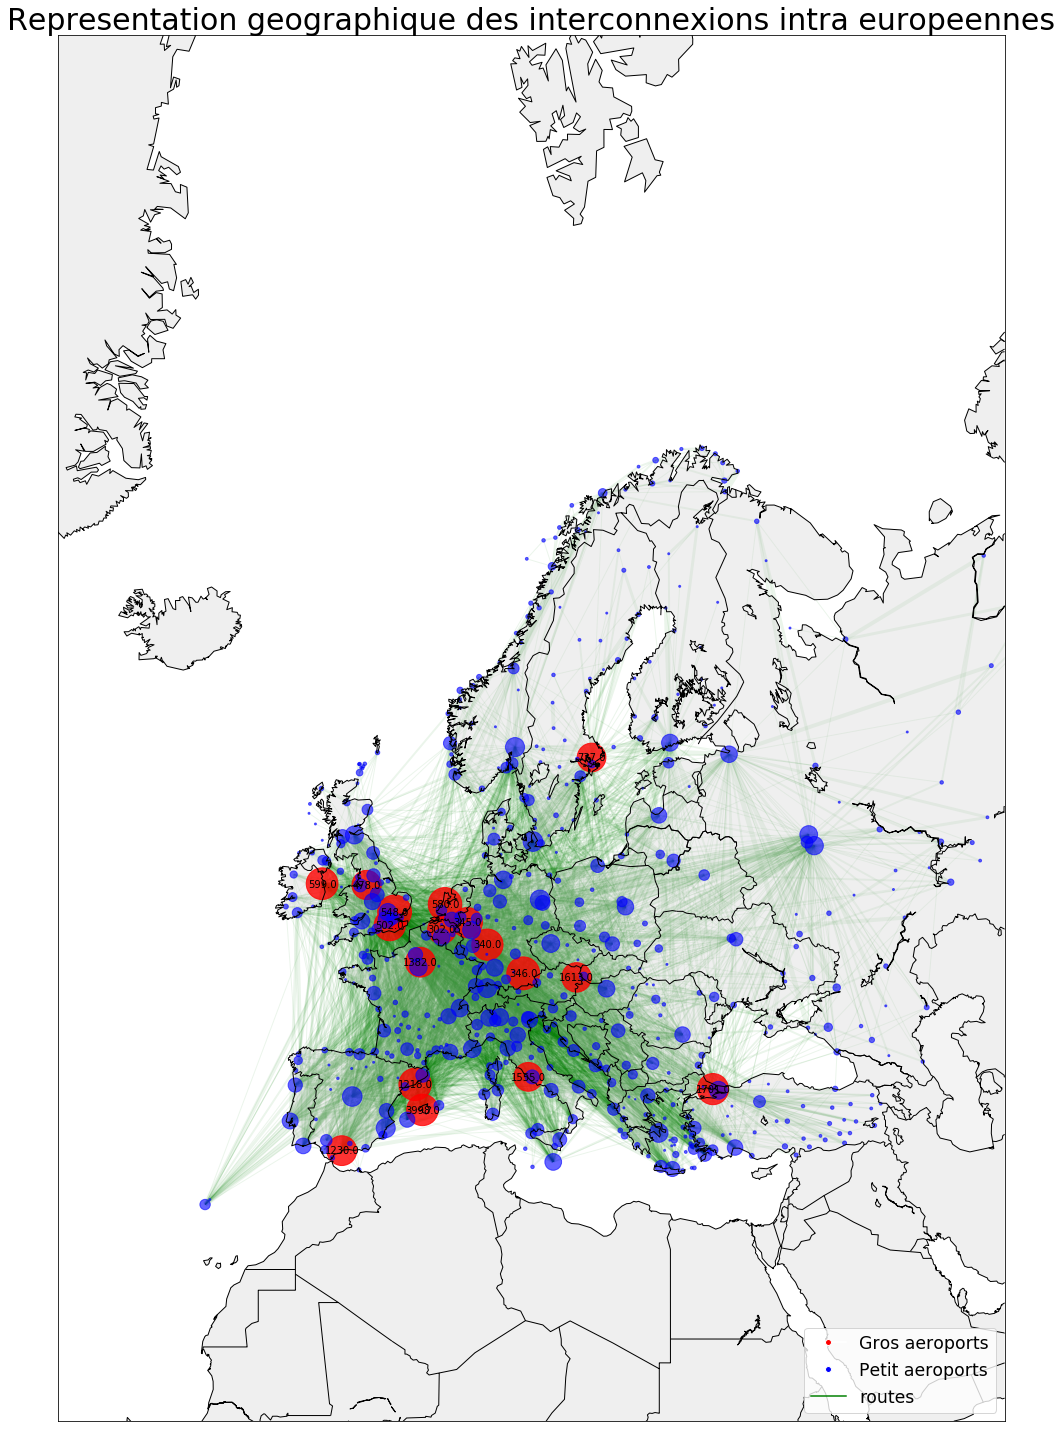

In [5]:
routes_european =  pd.DataFrame(routes_european.groupby(['id_aeroport_source', 'id_aeroport_destination']).size().reset_index(name='counts'))
counts = routes_european['id_aeroport_source'].append(routes_european.loc[routes_european['id_aeroport_source'] != routes_european['id_aeroport_destination'], 'id_aeroport_destination']).value_counts()
counts = pd.DataFrame({'id': counts.index, 'total_routes': counts})
counts.id = counts.id.astype(int)
title = str("Representation geographique des interconnexions intra europeennes")
nx, g = generate_geo_graph(european_airports, routes_european, counts, title)

##### CONNEXIONS ET DIRECTIONS

Est-ce que le graphe est dirigé ?

In [6]:
nx.is_directed(g)

False

Est-ce que le graphe est connecté ?

In [7]:
nx.is_connected(g)

True

##### DISTRIBUTION DES DEGRÉS DU GRAPHE

Le nombre de connexions de l'aéroport Paris CDG :

In [8]:
g.degree(1382)

111

Histogramme du nombre d'interconnexions entre les aéroports :

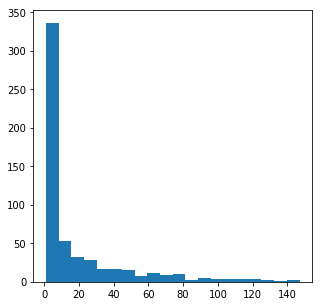

In [9]:
degree_sequence = [d for n, d in g.degree()]
plt.figure(figsize=(5,5))
plt.hist(degree_sequence, 20);

Le graphe montre un nombre important de noeuds ayant un degré faible faible et peu de noeuds avec un fort degré.

Le réseau aérien européen est hétérogène, de nombreux aéroports ont peu de connexion tandis que peu d'aéroports ont un nombre de connexions importantes. Ces aéroports servent de plateforme et permettent aux petits aéroports de communiquer avec le reste du réseau.

##### PARCIMONIE

In [10]:
nbNodes = nx.number_of_nodes(g)
print 'Le nombre de noeuds : ' + str(nbNodes)

Le nombre de noeuds : 561


In [11]:
nbEdges = nx.number_of_edges(g)
print 'Le nombre de connexions : ' + str(nbEdges)

Le nombre de connexions : 5203


In [12]:
density = nx.density(g)
print 'Le densité du graphe  : ' + str(density)

Le densité du graphe  : 0.0331232492997


Le graphe compte 563 noeuds et 5207 liens et n'est pas très dense. On peut dire que le graphe est parcimonieux, car le nombre de liens se rapproche plus du nombre de noeuds que du nombre de noeuds au carré.

##### PETIT MONDE

In [13]:
nx.diameter(g)

6

In [14]:
m.log(nbNodes)

6.329720905522696

Le diamètre du graphe 6 équivaut au diamètre du graph d'Erdős–Rényi alors il est petit monde.

##### COEFFICIENT DE CLUSTERING

In [15]:
nx.average_clustering(g)

0.44824797670743133

In [16]:
m.log(nbNodes)/nbNodes

0.011282924965281098

Le clustering du graphe est supérieur au clustering du graphe Erdős–Rényi alors le graphe a un coefficient de clustering élevé. L'ensemble les voisins d'un noeud sont connectés.

##### CENTRALITÉ DE L'INTERDÉPENDANCE ( BETWEENNESS CENTRALITY)

In [17]:
nx.betweenness_centrality(g)

{299.0: 0.0,
 302.0: 0.016166022659149553,
 304.0: 0.008282701611421237,
 309.0: 0.00012763890975232126,
 310.0: 0.0,
 337.0: 0.0038086062783156925,
 338.0: 6.337657854758927e-05,
 339.0: 1.1604728767966171e-06,
 340.0: 0.02132902803003024,
 341.0: 1.1768120645356029e-05,
 342.0: 0.005987142952822885,
 344.0: 0.009178187655433557,
 345.0: 0.024848001199406843,
 346.0: 0.03056819259131625,
 347.0: 0.0005642366919441368,
 348.0: 0.00016841157956640703,
 349.0: 3.709546461775872e-07,
 350.0: 0.004582738921480203,
 351.0: 0.014800980607178361,
 352.0: 0.0006411596267217399,
 353.0: 0.0012490577980886438,
 355.0: 0.002037599264844035,
 356.0: 0.0,
 362.0: 0.0,
 364.0: 2.209194004098884e-06,
 371.0: 1.6449409943858394e-06,
 373.0: 0.00175650591052547,
 374.0: 0.0,
 382.0: 0.00016689878552015583,
 393.0: 1.4382537410284422e-06,
 400.0: 1.1604728767966171e-06,
 410.0: 2.028241230899038e-07,
 413.0: 0.0,
 415.0: 0.011193302048549519,
 416.0: 0.0,
 421.0: 0.05750484641649068,
 428.0: 0.0,
 429.0

Plus le nœud est central et plus il est grand, il est donc naturel d'observer de fortes corrélations entre la betweenness centrality et le degré du noeud.

Noeud avec la plus grande centralité :

In [18]:
betweenness_centralities = nx.betweenness_centrality(g)
max_centrality = int(max(betweenness_centralities.keys(), key=(lambda key: betweenness_centralities[key])))
airports.loc[airports.index == max_centrality]

nom      ville    pays iata  oaci   latitude  \
id                                                                        
737  Stockholm-Arlanda Airport  Stockholm  Sweden  ARN  ESSA  59.651901   

     longitude  altitude fuseau_horaire continent fuseau_horaire_bdd     type  \
id                                                                              
737    17.9186       137              1         E   Europe/Stockholm  airport   

          source  
id                
737  OurAirports

Dans le cas où on ne prend pas en compte le nombre de vols et la distance kilométrique, on peut dire qu'il est un point central du réseau européen. Il permet à de nombreux aéroports de rejoindre leur destination. C'est une plateforme de correspondance aéroportuaire.

### REPRÉSENTATION GÉOGRAPHIQUE DES ROUTES EUROPÉENNES SANS LE MEILLEUR HUB

On retire le noeud avec le nombre total de routes le plus élevé de la liste des aéroports et des routes européennes.

In [19]:
best_airport =  int(counts.loc[counts['total_routes']== max(counts.total_routes)].id.values)
european_airports = european_airports.loc[european_airports.index != best_airport]
ids_airports_without_best = map(str, european_airports.index)
routes_european = routes_european[routes_european.id_aeroport_source.isin(ids_airports_without_best) & routes_european.id_aeroport_destination.isin(ids_airports_without_best)]
airports.loc[airports.index == best_airport]

nom   ville            pays iata  oaci   latitude  \
id                                                                           
548  London Stansted Airport  London  United Kingdom  STN  EGSS  51.884998   

     longitude  altitude fuseau_horaire continent fuseau_horaire_bdd     type  \
id                                                                              
548      0.235       348              0         E      Europe/London  airport   

          source  
id                
548  OurAirports

L'aéroport *London Stansted* et ses routes ont été retirés du réseau aérien européen.

On recalcule le nombre total de routes de chaque aéroport et on régénère le graphe.

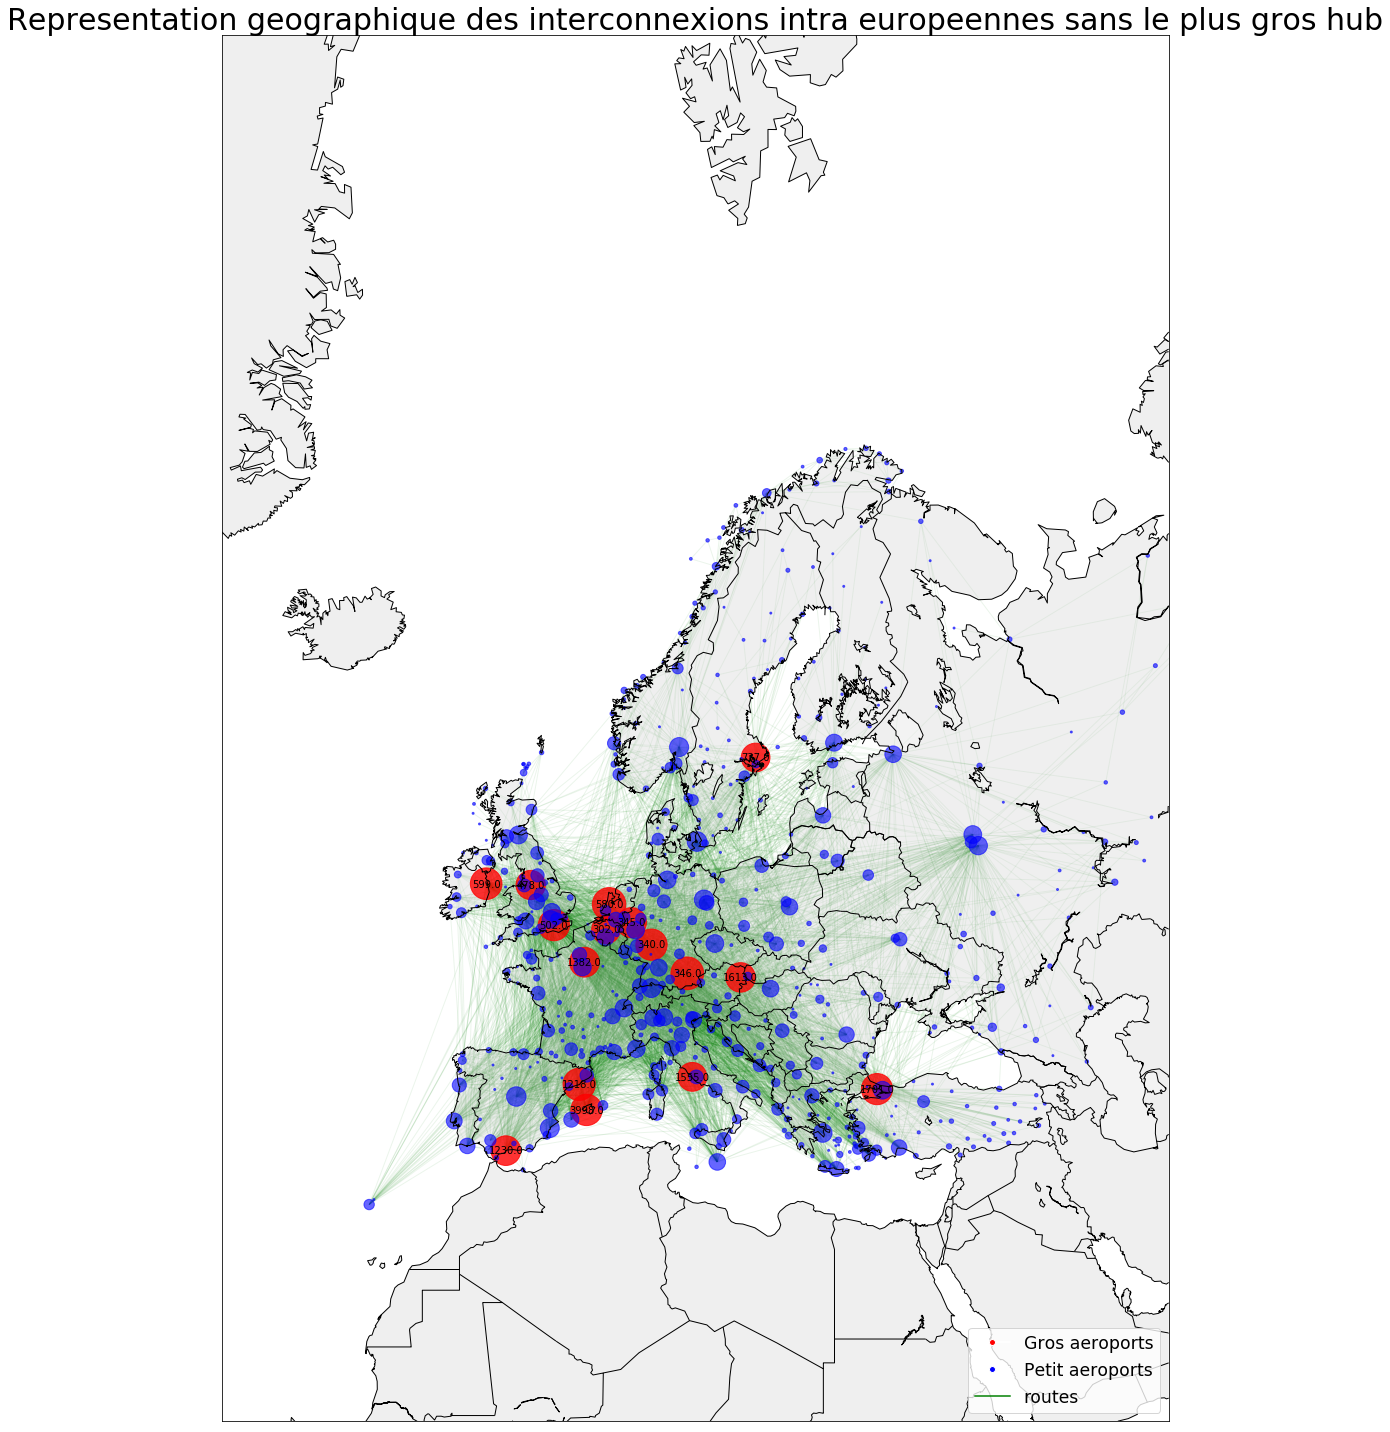

In [20]:
routes_european =  pd.DataFrame(routes_european.groupby(['id_aeroport_source', 'id_aeroport_destination']).size().reset_index(name='counts'))
counts = routes_european['id_aeroport_source'].append(routes_european.loc[routes_european['id_aeroport_source'] != routes_european['id_aeroport_destination'], 'id_aeroport_destination']).value_counts()
counts = pd.DataFrame({'id': counts.index, 'total_routes': counts})
counts.id = counts.id.astype(int)
title = "Representation geographique des interconnexions intra europeennes sans le plus gros hub"
nx, g_without_best = generate_geo_graph(european_airports,routes_european,counts,title)

Le graphique montre que la majorité des hubs du réseau sont concentrés sur la « dorsale européenne », zone qui va de Londres à Milan en passant par Francfort, dans laquelle se situent 47 % des villes d’Europe sur environ 18 % du territoire.

##### CONNEXIONS ET DIRECTIONS

Est-ce que le graphe est dirigé ?

In [21]:
nx.is_directed(g_without_best)

False

Est-ce que le graphe est connecté ?

In [22]:
nx.is_connected(g_without_best)

True

##### DISTRIBUTION DES DEGRÉS DU GRAPHE

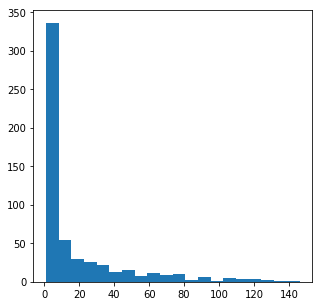

In [23]:
degree_sequence = [d for n, d in g_without_best.degree()]
plt.figure(figsize=(5,5))
plt.hist(degree_sequence, 20);

Le graphique est hétérogène, retirer le plus gros hub a peu d'impact sur la distribution des degrés du réseau.

##### PARCIMONIE

In [24]:
nbNodes = nx.number_of_nodes(g_without_best)
print 'Le nombre de noeuds : ' + str(nbNodes)

Le nombre de noeuds : 558


In [25]:
nbEdges = nx.number_of_edges(g_without_best)
print 'Le nombre de connexions : ' + str(nbEdges)

Le nombre de connexions : 5059


In [26]:
density = nx.density(g_without_best)
print 'Le densité du graphe  : ' + str(density)

Le densité du graphe  : 0.0325540690978


Le graphe compte 558 noeuds et 5069 liens. On peut dire que le graphe est parcimonieux, car le nombre de liens se rapproche plus du nombre de noeuds que du nombre de noeuds au carré.

Deux aéroports ont été retirés du réseau aérien, car il communiquait uniquement avec *London Stansted*. 144 routes ont également été supprimées.


##### PETIT MONDE

In [27]:
nx.diameter(g_without_best)

6

In [28]:
m.log(nbNodes)

6.324358962381311

Le diamètre du graphe avec et sans le plus gros hub est égal à 6. Le graphe basé sur le modèle Erdős–Rényi à un diamètre identique. On sait que le modèle Erdős–Rényi est un petit monde alors on peut dire que l'ensemble des graphes sont petits monde.

##### COEFFICIENT DE CLUSTERING

In [29]:
nx.average_clustering(g_without_best)

0.44880896526366193

In [30]:
m.log(nbNodes)/nbNodes

0.011333976635091956

Le clustering des deux graphes est supérieur au clustering du graphe Erdős–Rényi. Le graphe Erdős–Rényi à un coefficient de clustering faible alors les graphes ont un coefficient de clustering élevé.

Cela signifie que l'ensemble des aéroports voisins d'un aéroport sont connectés.

##### CENTRALITÉ DE L'INTERDÉPENDANCE ( BETWEENNESS CENTRALITY)

In [31]:
betweenness_centralities = nx.betweenness_centrality(g_without_best)
max_centrality = int(max(betweenness_centralities.keys(), key=(lambda key: betweenness_centralities[key])))
airports.loc[airports.index == max_centrality]

nom      ville    pays iata  oaci   latitude  \
id                                                                        
737  Stockholm-Arlanda Airport  Stockholm  Sweden  ARN  ESSA  59.651901   

     longitude  altitude fuseau_horaire continent fuseau_horaire_bdd     type  \
id                                                                              
737    17.9186       137              1         E   Europe/Stockholm  airport   

          source  
id                
737  OurAirports

Le fait de retirer le noeud ayant le plus de routes n'a pas eu d'impact sur le noeud qui a la plus forte centralité d'interdépendance.

### REPRÉSENTATION GÉOGRAPHIQUE DES ROUTES EUROPÉENNES SANS LES PRINCIPAUX HUBS

On retire les noeuds avec les plus grands nombres de routes de la liste des aéroports et des routes européennes.

In [32]:
best_airports =  counts.loc[counts['total_routes'] >= 200].id
european_airports = european_airports.loc[~european_airports.index.isin(best_airports)]
ids_airports_without_best = map(str, european_airports.index)
routes_european = routes_european[routes_european.id_aeroport_source.isin(ids_airports_without_best) & routes_european.id_aeroport_destination.isin(ids_airports_without_best)]

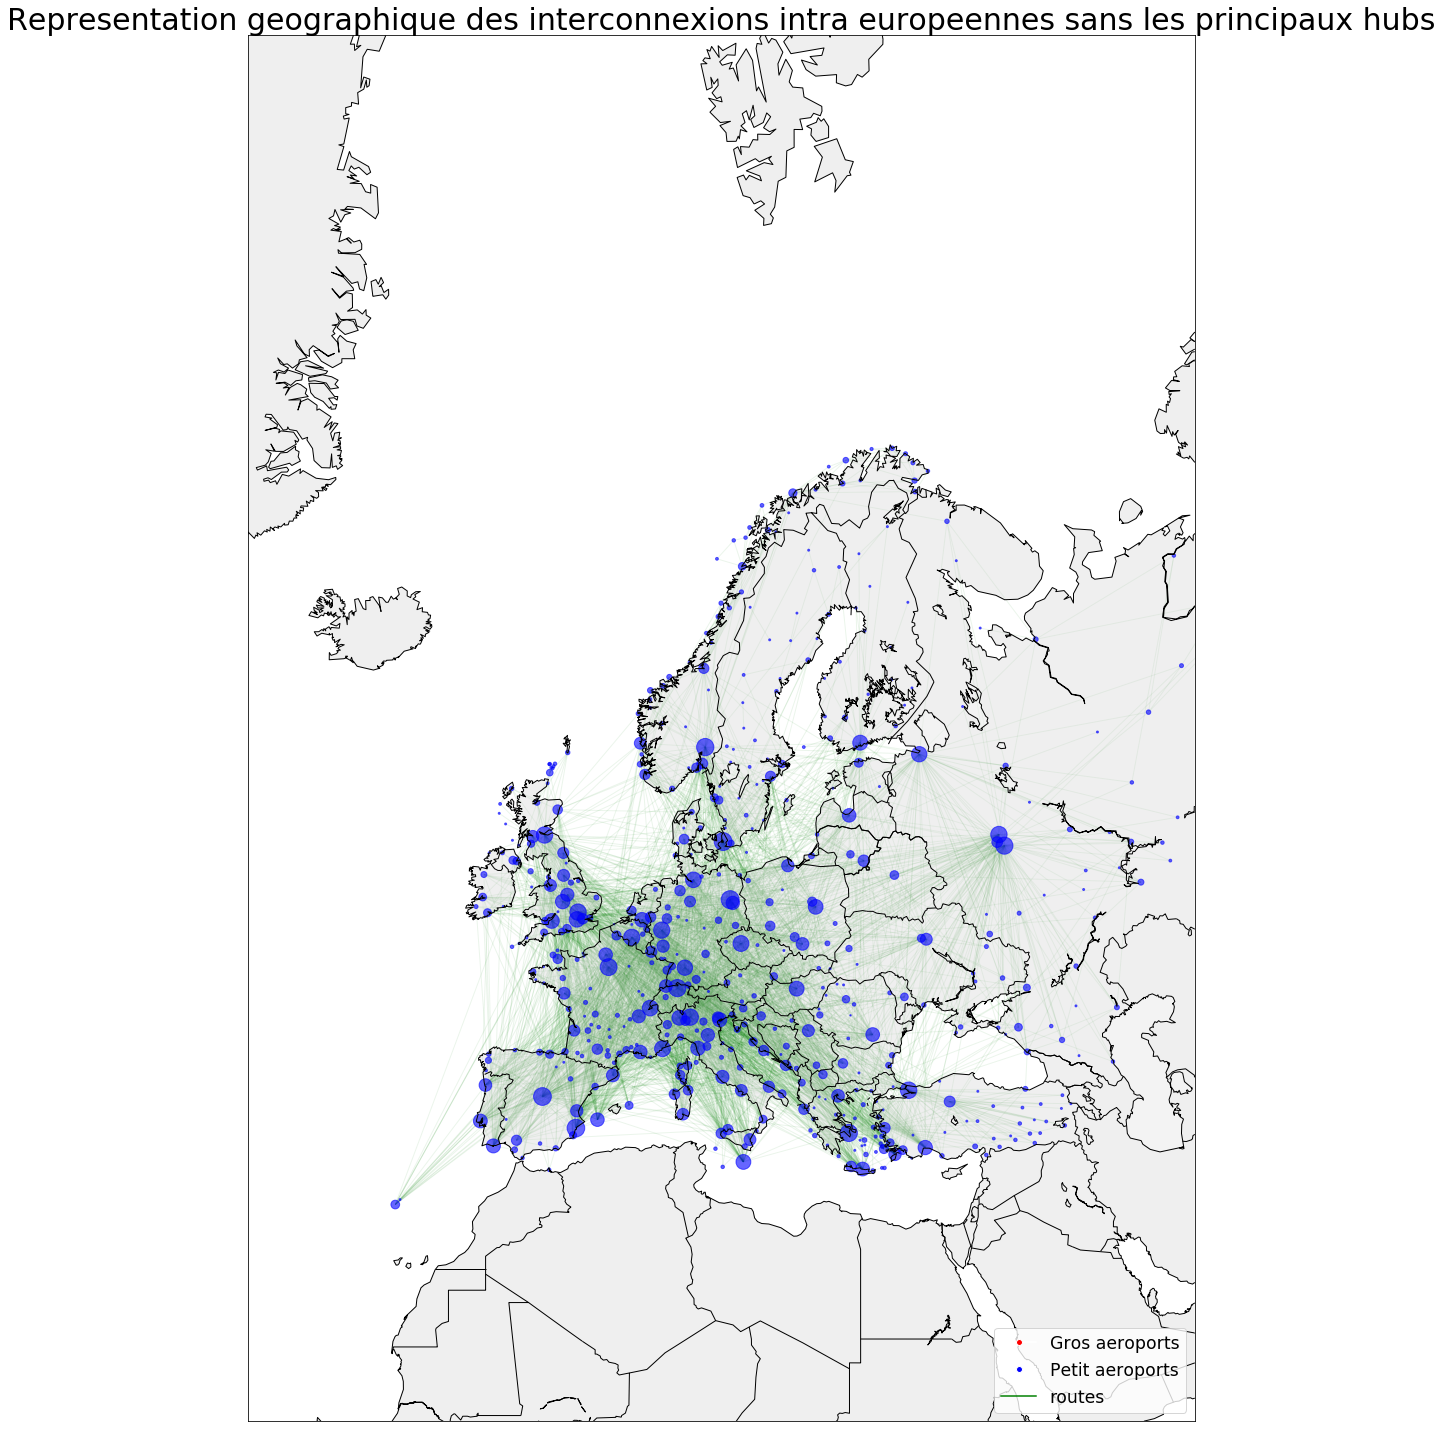

In [33]:
routes_european =  pd.DataFrame(routes_european.groupby(['id_aeroport_source', 'id_aeroport_destination']).size().reset_index(name='counts'))
counts = routes_european['id_aeroport_source'].append(routes_european.loc[routes_european['id_aeroport_source'] != routes_european['id_aeroport_destination'], 'id_aeroport_destination']).value_counts()
counts = pd.DataFrame({'id': counts.index, 'total_routes': counts})
counts.id = counts.id.astype(int)
title = "Representation geographique des interconnexions intra europeennes sans les principaux hubs"
nx, g_without_hubs  = generate_geo_graph(european_airports,routes_european,counts, title)

#### CONNEXIONS ET DIRECTIONS

Est-ce que le graphe est dirigé ?

In [34]:
nx.is_directed(g_without_hubs)

False

Est-ce que le graphe est connecté ?

In [35]:
nx.is_connected(g_without_hubs)

False

##### DISTRIBUTION DES DEGRÉS DU GRAPHE

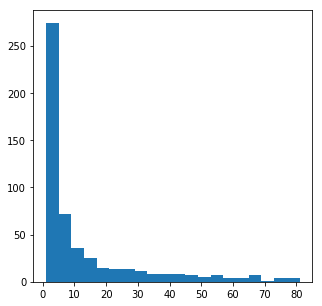

In [36]:
degree_sequence = [d for n, d in g_without_hubs.degree()]
plt.figure(figsize=(5,5))
plt.hist(degree_sequence, 20);

Retirer l'ensemble des hubs a peu d'impact sur la distribution des degrés du réseau. Cependant il y a moins de noeuds avec un très fort degré.

##### PARCIMONIE

In [37]:
nbNodes = nx.number_of_nodes(g_without_hubs)
print 'Le nombre de noeuds : ' + str(nbNodes)

Le nombre de noeuds : 528


In [38]:
nbEdges = nx.number_of_edges(g_without_hubs)
print 'Le nombre de connexions : ' + str(nbEdges)

Le nombre de connexions : 3282


In [39]:
density = nx.density(g_without_hubs)
print 'Le densité du graphe  : ' + str(density)

Le densité du graphe  : 0.0235897878213


Le graphe compte 528 noeuds et 3282 interconnexions et est encore moins dense qu'avant. Le graphe est parcimonieux cependant le fait d'avoir supprimé les principaux hubs a paralysé 33 aéroports et supprimé 1921 interconnexions entre les aéroports.

##### PETIT MONDE

Suite à la suppression des principaux hubs, l'ensemble des aéroports ne sont plus connectés. Le graphe ne peut donc plus être petit monde.

##### COEFFICIENT DE CLUSTERING

In [40]:
nx.average_clustering(g_without_hubs)

0.3676565443169123

In [41]:
m.log(nbNodes)/nbNodes

0.011873288416110343

Le clustering du graphe est nettement inférieur aux deux autres graphes. Il reste cependant supérieur au clustering du graphe Erdős–Rényi. Le graphe a un coefficient de clustering moyen. L'ensemble des aéroports voisins d'un aéroport sont moyennement connectés.

##### CENTRALITÉ DE L'INTERDÉPENDANCE ( BETWEENNESS CENTRALITY)

In [42]:
betweenness_centralities = nx.betweenness_centrality(g_without_hubs)
max_centrality = int(max(betweenness_centralities.keys(), key=(lambda key: betweenness_centralities[key])))
airports.loc[airports.index == max_centrality]

nom ville    pays iata  oaci  latitude  longitude  altitude  \
id                                                                           
644  Oslo Lufthavn  Oslo  Norway  OSL  ENGM    60.121    11.0502       681   

    fuseau_horaire continent fuseau_horaire_bdd     type       source  
id                                                                     
644              1         E        Europe/Oslo  airport  OurAirports

L'aéroport de Stockholm faisant partie des hubs, il a été retiré de la liste et a laissé sa place à l'aéroport d'Oslo.

## CONCLUSION

La structure du réseau aérien est solide. Il s'appuie sur un modèle qui hiérarchise le réseau en sous-réseaux emboîtés. Ce modèle souligne les groupes de villes plus inter-reliées entre elles qu’elles ne le sont avec le reste du système aérien et qui forment donc de « petits mondes ».

Ce modèle permet de ne pas paralyser l'ensemble du réseau aérien intra européen dans le cas où un hub est mis hors service. Cependant si tous les hubs sont retirés, presque la moitié des interconnexions sont impactées. Si ces derniers sont tous retirés, la connexion entre les voisins de chaque hub diminue fortement. Un hub a peu d'impact alors que l'ensemble des 
hubs jouent un rôle important dans l'ensemble du réseau.

Notre analyse porte uniquement sur les vols intra-européens, toutefois il serait judicieux d'effectuer cette même étude à l'échelle mondiale. Une majorité des aéroports européens ne communiquent pas avec tous les aéroports hors Europe. C'est là que les hubs prennent une place plus importante, car ce sont ces derniers qui permettent de faire la liaison avec le monde.

#### OUVERTURE

##### DISTANCE ORTHODROMIQUE

Cette partie n'est pas aboutie, mais l'idée était de récupérer la distance orthodromique (vol d'oiseau) entre deux aéroports et d'utiliser les distances comme poids pour les interconnexions entre les aéroports. On aurait pu comparer la distance kilométrique des plus courts chemins entre différents aéroports avant et après avoir retiré un hub du réseau.

In [49]:
def get_distance(lon1, lat1, lon2, lat2):
    # conversion des données en radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # inspirée de la formule haversine 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # le rayon de la terre
    km = 6371* c
    return km

In [50]:
# distances = {}
# for index, route in routes_european.iterrows() :
#     source_airport = routes_european['id_aeroport_source']
#     source_airport = airports.loc[source_airport]
#     destination_airport = routes_european['id_aeroport_destination']
#     destination_airport = airports.loc[destination_airport]
#     distances[index] = get_distance(source_airport['longitude'],source_airport['latitude'],destination_airport['longitude'],destination_airport['latitude'])

## RESSOURCES

* https://mappemonde-archive.mgm.fr/num7/articles/art05302.html
* https://openflights.org/data.html
* https://towardsdatascience.com/catching-that-flight-visualizing-social-network-with-networkx-and-basemap-ce4a0d2eaea6
* https://www.dataquest.io/blog/python-data-visualization-libraries/
* https://www.icao.int/Newsroom/Pages/FR/Continued-passenger-traffic-growth-and-robust-air-cargo-demand-in-2017.aspx

Projet réalisé par : 
    
* Marty Marc-Antoine
* Thubé Pierre
* Chevillard Cedric